In [1]:
%cd ..

/media/Z/NDT/PytorchLightning/4. NLP


In [6]:
import typing
import torch
import datasets
import pytorch_lightning as pl
import pdb
from transformers import (
    AdamW,
    AutoConfig,
    AutoModelForTokenClassification,
    AutoTokenizer,
    get_linear_schedule_with_warmup,
)
import os
from torch.utils.data import DataLoader
from dataset.ner_dataloader import NerDataset
from configs import *

class NERModelModule(pl.LightningModule):
    def __init__(
        self,
        model_name_or_path: str,
        num_labels: int,
        tags_list: typing.List[str],
        precision: int = 32,
        learning_rate: float = 2e-5,
        adam_epsilon: float = 1e-8,
        warmup_steps: int = 0,
        weight_decay: float = 0.0,
        train_batch_size: int = 32,
        eval_batch_size: int = 32,
        **kwargs,
    ):
        super().__init__()
        self.tags_list = tags_list
        self.save_hyperparameters() 
        self.config = AutoConfig.from_pretrained(model_name_or_path, num_labels=num_labels)
        self.model = AutoModelForTokenClassification.from_pretrained(model_name_or_path, config=self.config) 
        self.tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True)
        self.learning_rate  = learning_rate
        self.example_input_array = {
            'input_ids': torch.randint(3, 2000, (16, 128)).type(torch.LongTensor) ,
            'attention_mask':  torch.ones(16, 128),
            'labels':  torch.ones(16, 128).type(torch.LongTensor) 
        }
        self.metrics = datasets.load_metric('seqeval') 
        self.train_data = NerDataset(
            dataset_path=os.path.join(PATH_DATASET, 'version_2', 'train_data.txt'),
            model_name_or_path=model_name_or_path,
            tags_list=self.tags_list,
            max_seq_length=152,
            label_all_tokens=False)
    def forward(self, **inputs):
        return self.model(**inputs)

    def training_step(self, batch, batch_idx):
        outputs = self(**batch)
        loss = outputs[0]
        self.log('train_loss', loss, prog_bar=True)

        return loss
    def train_dataloader(self):
        from torch.utils.data import DataLoader
        return DataLoader(self.train_data, batch_size=4)
    def configure_optimizers(self):
        """Prepare optimizer and schedule (linear warmup and decay)"""
        model = self.model
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": self.hparams.weight_decay,
            },
            {
                "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
        ]
        optimizer = AdamW(optimizer_grouped_parameters, lr=self.learning_rate, eps=self.hparams.adam_epsilon)
        return [optimizer]

In [7]:
from configs import *

In [8]:
%%capture
model_module = NERModelModule(model_name_or_path=BASE_MODEL_NAME,
                        num_labels=len(TAGS),
                        tags_list=TAGS
                        )

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-st

In [9]:
from pytorch_lightning import seed_everything, Trainer

In [10]:
trainer = Trainer(auto_lr_find=True,accelerator="gpu")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [11]:
lr_finder = trainer.tuner.lr_find(model_module)

/home/administrator/.virtualenvs/ndt98/lib/python3.8/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
Missing logger folder: /media/Z/NDT/PytorchLightning/4. NLP/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
/home/administrator/.virtualenvs/ndt98/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/home/administrator/.virtualenvs/ndt98/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argume

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=93` reached.
LR finder stopped early after 93 steps due to diverging loss.
Restoring states from the checkpoint path at /media/Z/NDT/PytorchLightning/4. NLP/.lr_find_3e0255ba-6092-427d-be92-3d7149927811.ckpt
Restored all states from the checkpoint file at /media/Z/NDT/PytorchLightning/4. NLP/.lr_find_3e0255ba-6092-427d-be92-3d7149927811.ckpt


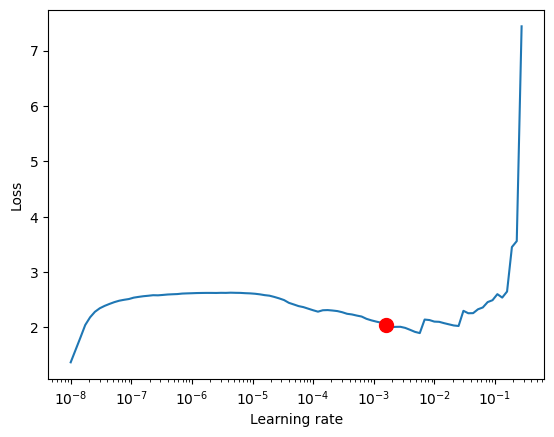

In [12]:
fig = lr_finder.plot(suggest=True)

In [13]:
lr_finder.suggestion()

0.001584893192461114